#Librairies

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=10e067928e2b9ebcaeeaa00bd296b5187a6c8e4f5e74cd46cc7ff4499f16c0d7
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=d8d036e39668e192ec33907564930f2b059b651060f0a5f0bf77796f26d98004
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
### Mandatory
import numpy as np
import pandas as pd
import cv2
import datetime as dt
import time

### Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px

### Collab and options
from google.colab import drive
import sys
import os
drive.mount('/content/gdrive')
pd. set_option('display.max_rows', 500)
pd. set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 800)
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

### Sklearn
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn import cluster, metrics
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import umap

Mounted at /content/gdrive


# Importing Data

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Flipkart/flipkart_com-ecommerce_sample_1050.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Here I will need 2 columns : 

- Image, which is the corresponding .jpg files
- Product_category_tree, which we will update to keep only root

In [ ]:
df_image = df[['image', 'product_category_tree']]
df_image.head(10)

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   
5  893aa5ed55f7cff2eccea7758d7a86bd.jpg   
6  f355cc1ccb08bd0d283ed979b7ee7515.jpg   
7  dd0e3470a7e6ed76fd69c2da27721041.jpg   
8  41384da51732c0b4df3de8f395714fbb.jpg   
9  710ed5f2393a4b9e8823aa0029f71f93.jpg   

                                                                                                                       product_category_tree  
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]  
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]  
2   ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]  
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]  
4             ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]  
5                                                                                ["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]  
6                                                                                      ["Watches >> Wrist Watches >> Camerii Wrist Watches"]  
7                                                                                       ["Watches >> Wrist Watches >> T STAR Wrist Watches"]  
8                                                                                       ["Watches >> Wrist Watches >> Alfajr Wrist Watches"]  
9                                                                                    ["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]

In [ ]:
df_image['product_category_tree'] = df_image['product_category_tree'].apply(lambda x : x.replace(">>", "_")).apply(lambda x : '/'.join(x.split('_')[0:1])).apply(lambda x : x.lstrip('["'))
print(df_image['product_category_tree'].unique())

['Home Furnishing ' 'Baby Care ' 'Watches ' 'Home Decor & Festive Needs '
 'Kitchen & Dining ' 'Beauty and Personal Care ' 'Computers ']


In [ ]:
le = LabelEncoder()
df_image['cluster'] = le.fit_transform(df_image['product_category_tree'])
df_image.head(10)

image product_category_tree  cluster
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg      Home Furnishing         4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg            Baby Care         0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg            Baby Care         0
3  d4684dcdc759dd9cdf41504698d737d8.jpg      Home Furnishing         4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg      Home Furnishing         4
5  893aa5ed55f7cff2eccea7758d7a86bd.jpg              Watches         6
6  f355cc1ccb08bd0d283ed979b7ee7515.jpg              Watches         6
7  dd0e3470a7e6ed76fd69c2da27721041.jpg              Watches         6
8  41384da51732c0b4df3de8f395714fbb.jpg              Watches         6
9  710ed5f2393a4b9e8823aa0029f71f93.jpg              Watches         6

While we used text data, we had 150 items per group let's see if the repartition has been kept here.

In [ ]:
df_image['product_category_tree'].value_counts()

Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: product_category_tree, dtype: int64

In [ ]:
df_image.set_index('cluster')['product_category_tree'].to_dict()

{4: 'Home Furnishing ',
 0: 'Baby Care ',
 6: 'Watches ',
 3: 'Home Decor & Festive Needs ',
 5: 'Kitchen & Dining ',
 1: 'Beauty and Personal Care ',
 2: 'Computers '}

Label 0 : Baby Care

Label 1 : Beauty and Personal Care

Label 2 : Computers

Label 3 : Home Decor & Festive Needs

Label 4 : Home Furnishing

Label 5 : Kitchen & Dining 

Label 6 : Watches
 

In [ ]:
image_path = "/content/gdrive/MyDrive/Flipkart/Images/"

image_list = [f for f in os.listdir(image_path)]
print(f'We will have to classify {len(image_list)} images')

We will have to classify 1053 images


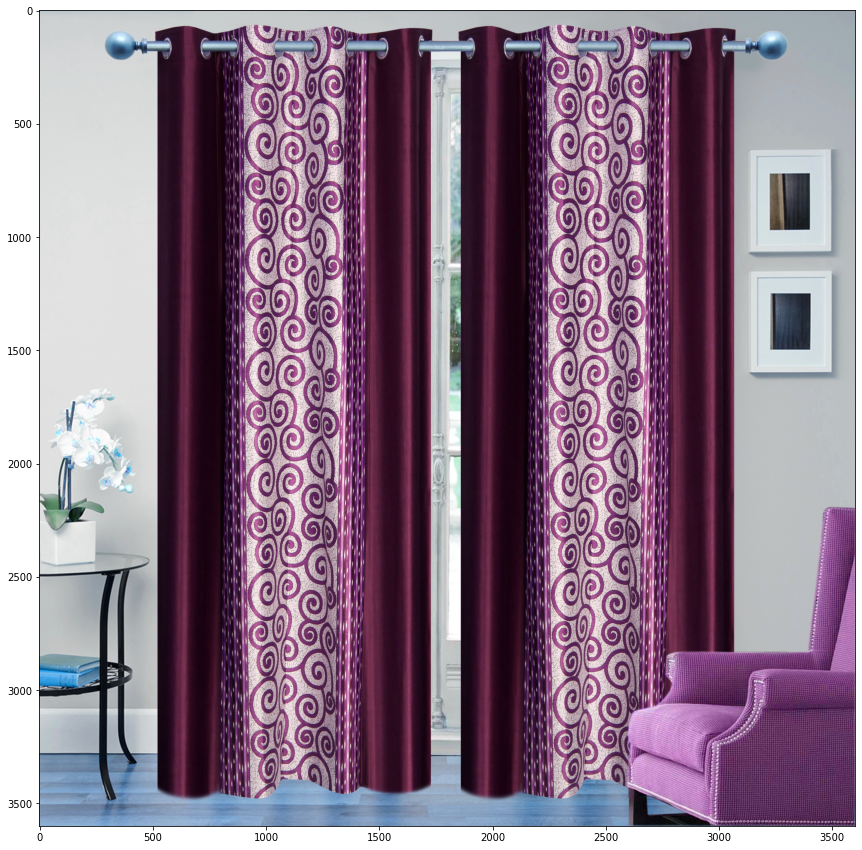

In [ ]:
im = cv2.imread(image_path+df_image.image[0])
plt.figure(figsize=(15,15))
plt.imshow(im)

Home Furnishing 


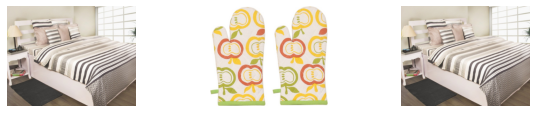

Baby Care 


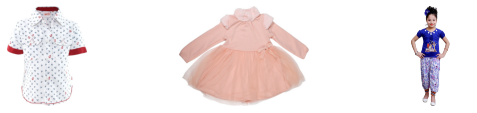

Watches 


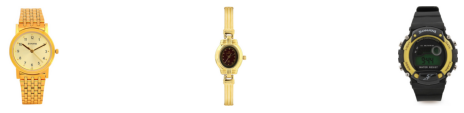

Home Decor & Festive Needs 


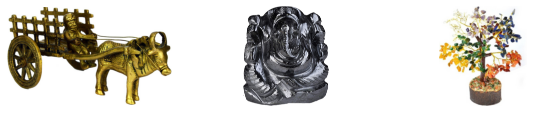

Kitchen & Dining 


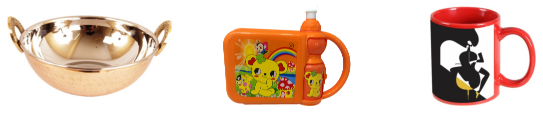

Beauty and Personal Care 


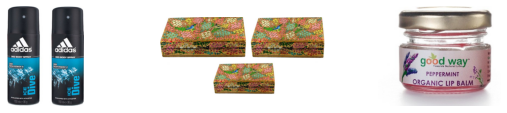

Computers 


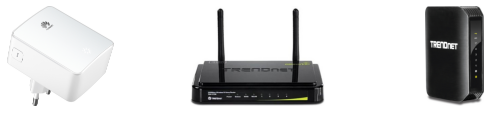

In [ ]:
for name in df_image['product_category_tree'].unique() :
    plt.figure(figsize=(10,15))
    print("="*50)
    print('\033[1m' + name)
    print("="*50)
    for i in range(3):
        plt.subplot(7, 3, i + 1)
        for j in df_image[df_image["product_category_tree"]==name].image.sample():
          filename = image_path + j
          image = cv2.imread(filename)
          image = image[...,::-1]
          plt.axis('off')
          plt.imshow(image)
         
    plt.show()

Note that openCV colors are in BGR so we have to get it back to RGB 

# Functions

In [ ]:
### Calculation of ARI SCORE 
def ari_scoring(result) :
  perplex = (df_image.shape[0])**((1/2))
  true_lab = df_image['cluster']
  tsne = TSNE(n_components=2, perplexity=perplex, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
  result_TSNE = tsne.fit_transform(result)
  pred = KMeans(n_clusters = df_image['cluster'].nunique(), random_state=42)
  pred.fit(result_TSNE)
  pred_lab = pred.labels_
  ARI_Score = np.round(adjusted_rand_score(true_lab, pred_lab), 3)
  print("ARI Score is : ", ARI_Score)

  return ARI_Score, result_TSNE, pred_lab

### Plotting
def plotting(result_TSNE, true_lab, labels, ARI_Score) :
  fig = plt.figure(figsize=(25,12))
  ax = fig.add_subplot(121)
  scatter = ax.scatter(result_TSNE[:,0],result_TSNE[:,1], c=true_lab, cmap='Set1')
  ax.legend(handles=scatter.legend_elements()[0], labels=list(set(df_image['product_category_tree'])), loc="best", title="Categorie")
  plt.title('2D graph representing products in their real categories.')
  ax = fig.add_subplot(122)
  scatter = ax.scatter(result_TSNE[:,0],result_TSNE[:,1], c=labels, cmap='Set1')
  ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
  plt.title('2D graph representing products by clustering.')
    
  plt.show()


### Confusion matrix 

def conf_matrix(real, predicted, ARI_Score) :
  cm = confusion_matrix(real, predicted)
  plt.figure(figsize=(20,7))
  sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'rocket_r');
  plt.ylabel('Actual Class');
  plt.xlabel('Predicted Class');
  all_sample_title = "ARI_Score: %0.2f" % (ARI_Score)
  plt.title(all_sample_title, size = 15)

  plt.show()

# SIFT Method

## Image Preprocessing

In [ ]:
df_image['width']=df_image['height']=df_image['channel']=""

for index, row in df_image.iterrows() : 
  link = row['image']
  im = cv2.imread(image_path+link)
  h, w, c = im.shape
  df_image.at[index, 'width'] = w
  df_image.at[index, 'height'] = h
  df_image.at[index, 'channel'] = c

df_image.sample(10)

image        product_category_tree  \
859   eedee8680f0ed35dcf612c6774affe83.jpg                   Computers    
1027  362714cbba2f5ae412d2f26bae99a266.jpg             Home Furnishing    
723   7c785e9e26092c0b6ed038085e90d89d.jpg             Home Furnishing    
679   6c441a6ca8eb4e5ca882c9c0df03ff0c.jpg  Home Decor & Festive Needs    
602   c91f9dc1fdd8b4d60c6b2a2b607e3e8f.jpg                     Watches    
990   e347e7eca70e01badc3bdf6c154ac7c4.jpg                   Baby Care    
693   c6adf41cd378b1f6a7ac62675b060411.jpg  Home Decor & Festive Needs    
798   9993de7e2bcced43dc9edb3b2c81f23d.jpg    Beauty and Personal Care    
43    2d50e4c6ccf8befe9335ac8f97a11712.jpg    Beauty and Personal Care    
533   5db6bd89da44841c1a5b686e67137704.jpg                     Watches    

      cluster width height channel  
859         2  1900   1635       3  
1027        4  3812   3812       3  
723         4   936    320       3  
679         3  1008   1277       3  
602         6   974   1480       3  
990         0  3006   4299       3  
693         3  1192    870       3  
798         1  1100    554       3  
43          1   409   1100       3  
533         6   232    504       3

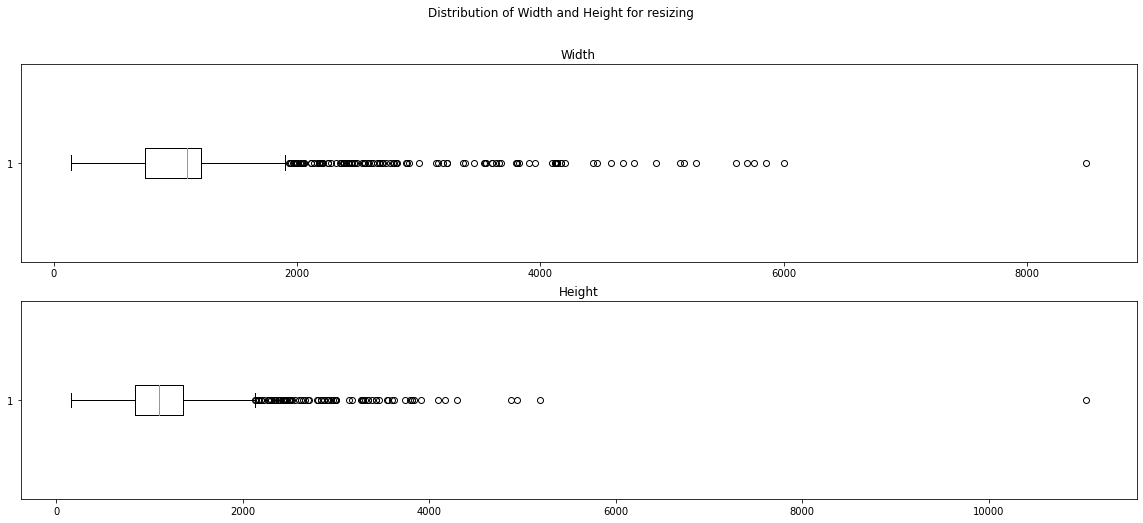

In [ ]:
fig, axs = plt.subplots(2, figsize=(20,8))
fig.suptitle('Distribution of Width and Height for resizing')
axs[0].boxplot(df_image['width'], vert=False)
axs[0].set_title('Width')
axs[1].boxplot(df_image['height'], vert=False)
axs[1].set_title('Height')
plt.show()

In [ ]:
print("min width :",df_image['width'].min(),
      "\nmin height :", df_image['height'].min())

min width : 145 
min height : 160


We will resize every image of the dataset to a single size 224x224 (For further use in CNN transfert learning).

In [ ]:
def resize2SquareKeepingAspectRation(img, size, interpolation):
    """
    Resizing in (size, size) and adding white bands to not stretch the image
    
    """
    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]
    if h == w:
        return cv2.resize(img, (size, size), interpolation)
    if h > w:
        dif = h
    else:     
        dif = w
    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)
    if c is None:
        mask = 255*np.ones((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos + h, x_pos:x_pos + w] = img[:h, :w]
    else:
        mask = 255*np.ones((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos + h, x_pos:x_pos + w, :] = img[:h, :w, :]
    return cv2.resize(mask, (size, size), interpolation)

In [ ]:
image_size = 224
dir_images_transformed = image_path + "Images_transformed/"

In [ ]:
from PIL import Image, ImageOps
from PIL import ImageFilter

preprocess_image = False
Images = []

if preprocess_image:

    for name_img in df_image["image"] :

        img = Image.open(os.path.join(image_path, name_img)) # Image Reading
        img = ImageOps.autocontrast(img) # Autocontrast
        img = ImageOps.equalize(img) # equalizer
        img = img.filter(ImageFilter.BoxBlur(1)) # Noise reduction
        img = resize2SquareKeepingAspectRation(np.array(img), image_size, cv2.INTER_AREA) # Resize en 224*224
        Images.append(img)
        img = Image.fromarray(img) # Array to image
        img.save(os.path.join(dir_images_transformed, name_img)) # Saving

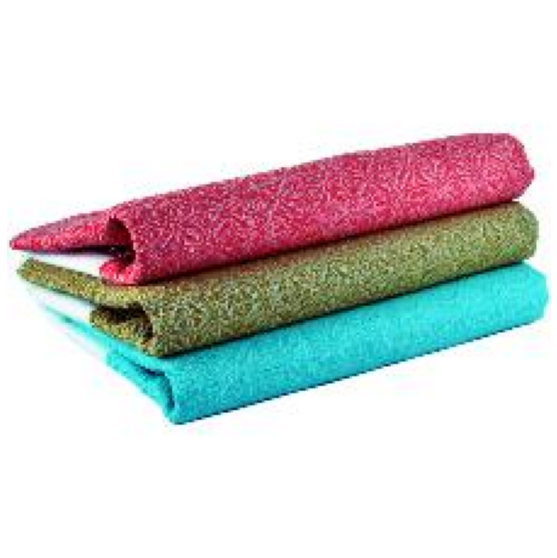

In [ ]:
### Test Image, Original one

image = cv2.imread(dir_images_transformed+df_image['image'][1])
image = image[...,::-1]
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image)
plt.show()

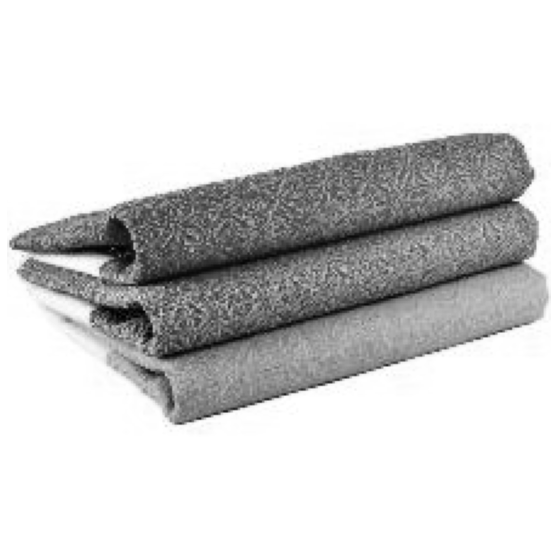

In [ ]:
### Test Image, Greyscaled

imgG = cv2.imread(dir_images_transformed+df_image['image'][1])
imgG = cv2.cvtColor(imgG, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(imgG, cmap='gray')
plt.show()

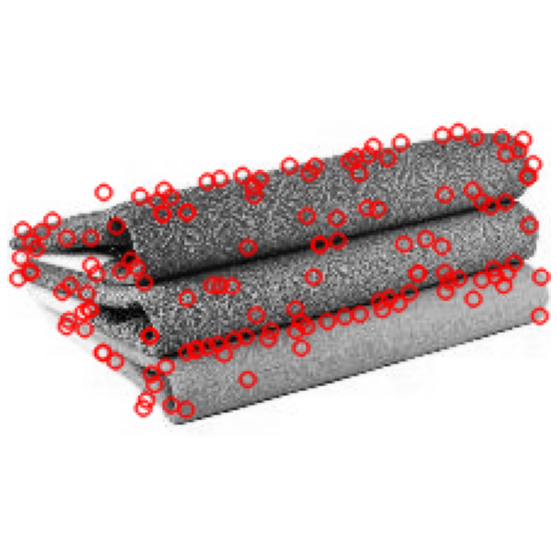

In [ ]:
### Test Image, ORB feature detection

SIFT_object = cv2.SIFT_create()
keypoints = SIFT_object.detect(imgG)
keypoints, descriptors = SIFT_object.compute(imgG, keypoints)
imgRes = cv2.drawKeypoints(imgG, keypoints, None, color=(255,0,0), flags=0)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(imgRes, cmap='gray')
plt.show()

In [ ]:
def preprocess_image(image) :
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

## Feature Matching

Let's try feature matching on 2 cases : 

- First we will try feature matching on same category (Watches)
- Second we will try feature matching on different categories (Watches & Baby Care)

In [ ]:
### Watches

df_watches = df_image.loc[df_image['product_category_tree'] == "Watches "].reset_index(drop=True)

train = dir_images_transformed+df_watches['image'][7]
test = dir_images_transformed+df_watches['image'][20]

In [ ]:
train = preprocess_image(train)
test = preprocess_image(test)

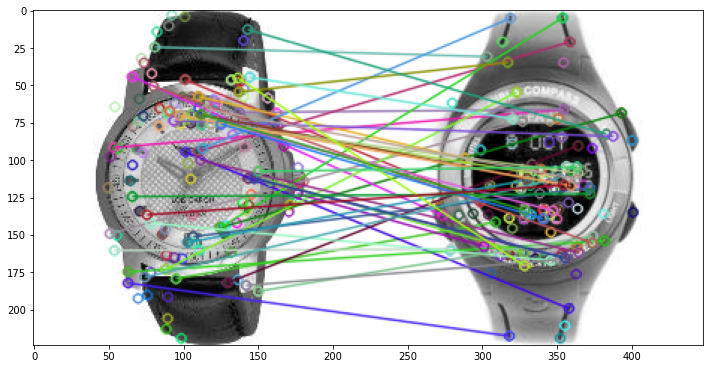

In [ ]:
sift = cv2.SIFT_create(nfeatures = 150)

kp_train, des_train = sift.detectAndCompute(train,None)
kp_test, des_test = sift.detectAndCompute(test,None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(des_train,des_test)

matches = sorted(matches, key = lambda x:x.distance)

img_match = cv2.drawMatches(train,kp_train,test,kp_test,matches[:50], None, flags=0)
plt.figure(figsize=(12,12))
plt.imshow(img_match, cmap='gray')
plt.show()

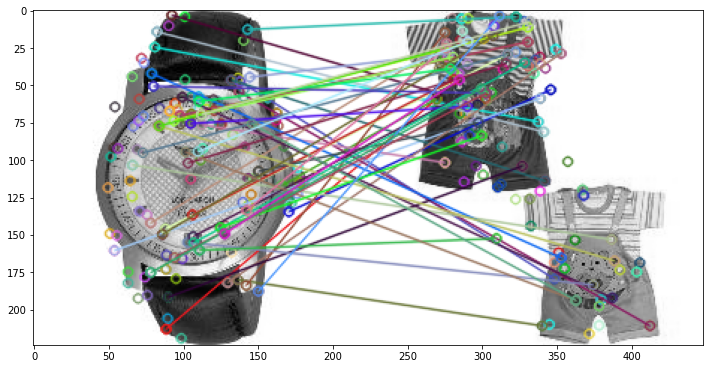

In [ ]:
### Watche and Baby Care 

df_baby = df_image.loc[df_image['product_category_tree'] == "Baby Care "].reset_index(drop = True)

train = dir_images_transformed+df_watches['image'][7]
test = dir_images_transformed+df_baby['image'][20]

train = preprocess_image(train)
test = preprocess_image(test)

sift = cv2.SIFT_create(nfeatures = 150)

kp_train, des_train = sift.detectAndCompute(train,None)
kp_test, des_test = sift.detectAndCompute(test,None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(des_train,des_test)

matches = sorted(matches, key = lambda x:x.distance)

img_match = cv2.drawMatches(train,kp_train,test,kp_test,matches[:50], None, flags=0)
plt.figure(figsize=(12,12))
plt.imshow(img_match, cmap='gray')
plt.show()

Feature matching makes sense between 2 items of the same category but not in the other case. For now we will get for each image, their keypoints and descriptors in order to create the equivalent of Bag Of Word in NLP.

In [ ]:
def get_kp_desc(img):
  """ Get Keypoints and Descriptors using SIFT """
  sift = cv2.SIFT_create(nfeatures = 500) ### nfeatures = 500 -> best ari score at the end
  kp, des = sift.detectAndCompute(img,None)
  return kp, des

In [ ]:
sift_keypoints = []
for link in range(len(df_image['image'])) :
    img = preprocess_image(dir_images_transformed+df_image['image'][link])
    kp, des = get_kp_desc(img)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype='object')
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

In [ ]:
# Number of clusters
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Number of calculated clusters : ", k)

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
kmeans.fit(sift_keypoints_all)

Number of calculated clusters :  511


MiniBatchKMeans(init_size=1533, n_clusters=511, random_state=42)

In [ ]:
def build_histogram(kmeans, des, image_num):
    """Visual BOW based on a Kmeans"""   
    pred = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("histogram image problem  : ", image_num)
    for i in pred:
        hist[i] += 1.0/nb_des
    return hist

In [ ]:
# Building Histogram Matrix
hist_vectors=[]
for i, image_desc in enumerate(sift_keypoints_by_img) : 
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)
im_features = np.asarray(hist_vectors)

## Dimension Reduction and Plot

In [ ]:
### Let's standardize 
im_norm = sklearn.preprocessing.StandardScaler().fit_transform(im_features)

ARI Score is :  0.042


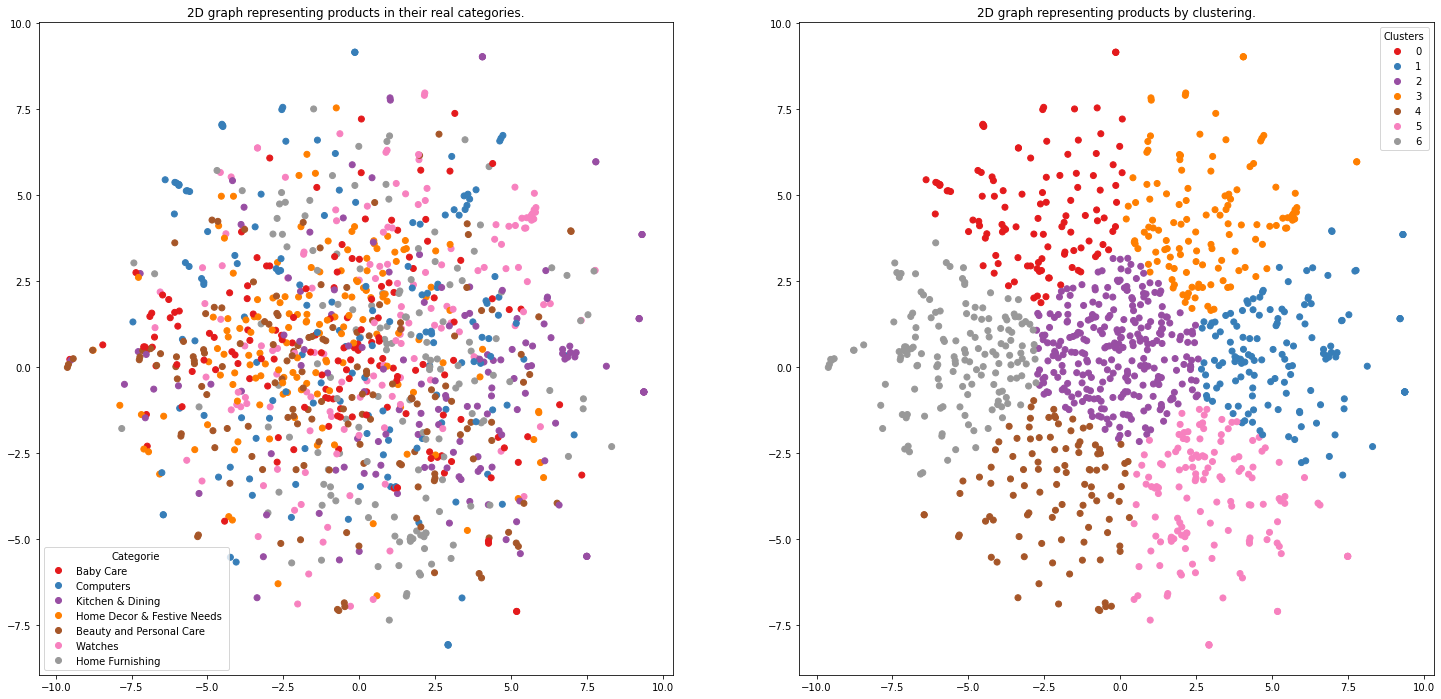

In [ ]:
ARI_Score, result_TSNE, pred_lab = ari_scoring(im_norm)

plotting(result_TSNE, df_image['cluster'], pred_lab, ARI_Score)

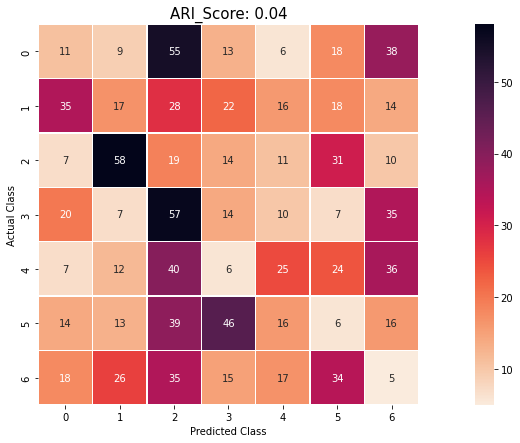

In [ ]:
conf_matrix(df_image['cluster'], pred_lab, ARI_Score)

SIFT method is not a good choice here, just out of curiosity, I would like to try to reduce dimensionality with UMAP.

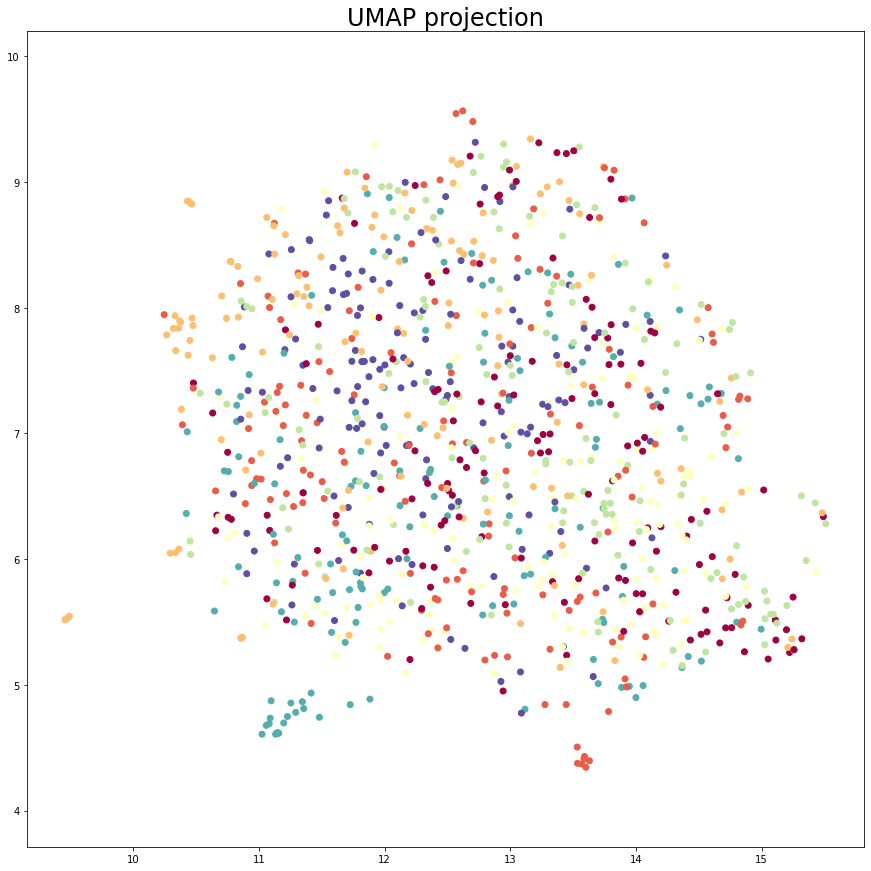

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(im_norm)
plt.figure(figsize=(15,15))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=df_image.cluster,
    cmap= "Spectral")
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)
plt.show()

As we can see, it is the same result with UMAP.

Let's try with a CNN model !

# CNN Transfert Learning (ResNet 50)

![Image in a markdown cell]( https://miro.medium.com/max/640/1*0W310-cMNHPWjErqPuGXpw.webp) 

We can see here most famous pretrained model and their performance on ImageNet dataset.

Based on Stanford Computer Vision Course, Convolutional Neural Networks (CNN) architecture is repeated sequence of CONVOLUTIONAL -> RELU (-> POOL) layers and at the end a Fully Connected layer to predict categories.

In our case FC layer will have 7 differents outputs.

## Librairies

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Creating 7 folders with all images of each categories to train ResNet50

In [ ]:
final_dir = "/content/gdrive/MyDrive/Flipkart/Images/resnet50_training/"

In [ ]:
# for index, row in df_image.iterrows() :
#   name_img = row['image']
#   folder_dir = row['product_category_tree']
#   out = final_dir+folder_dir
#   img = Image.open(os.path.join(image_path, name_img))
#   img.save(os.path.join(out, name_img))

## Implementation of chosen model

In [ ]:
img_height, img_width = 224,224
batch_size = 30

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  final_dir,
  validation_split=0.4,
  label_mode= 'categorical',
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1050 files belonging to 7 classes.
Using 630 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  final_dir,
  validation_split=0.4,
  subset="validation",
  label_mode= 'categorical',
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1050 files belonging to 7 classes.
Using 420 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Baby Care ', 'Beauty and Personal Care ', 'Computers ', 'Home Decor & Festive Needs ', 'Home Furnishing ', 'Kitchen & Dining ', 'Watches ']


In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
                  include_top=False,
                  input_shape=(224,224,3),
                  pooling='avg',classes=7,
                  weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(7, activation='softmax'))


resnet_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 1,052,679
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=5
history = resnet_model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/5
21/21 [==============================] - 443s 16s/step - loss: 1.4454 - accuracy: 0.6222 - val_loss: 0.5893 - val_accuracy: 0.7976
Epoch 2/5
21/21 [==============================] - 9s 354ms/step - loss: 0.3715 - accuracy: 0.8889 - val_loss: 0.7269 - val_accuracy: 0.7762
Epoch 3/5
21/21 [==============================] - 9s 351ms/step - loss: 0.1637 - accuracy: 0.9556 - val_loss: 0.7252 - val_accuracy: 0.7810
Epoch 4/5
21/21 [==============================] - 9s 347ms/step - loss: 0.0572 - accuracy: 0.9968 - val_loss: 0.7501 - val_accuracy: 0.7833
Epoch 5/5
21/21 [==============================] - 8s 343ms/step - loss: 0.0292 - accuracy: 0.9984 - val_loss: 0.7144 - val_accuracy: 0.7929


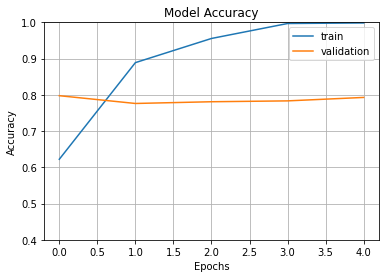

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

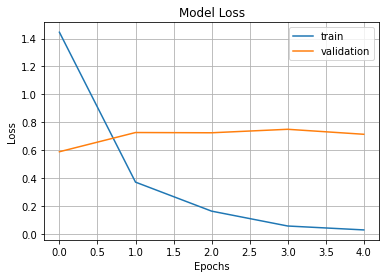

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

We can see that validation accuracy and loss are stable.

Let's predict classes !

In [ ]:
class_name = train_ds.class_names
result_prediction = {}
for image_num in range(df_image.shape[0]):
    image = image_path+df_image['image'][image_num]
    image = cv2.imread(image)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0) 
    output_class = resnet_model.predict(image)
    output_class = class_name[np.argmax(output_class)]
    result_prediction[image_num] = output_class

1/1 [==============================] - 0s 21ms/step


In [ ]:
result_prediction = pd.DataFrame.from_dict(result_prediction, orient = 'index').reset_index().rename(columns={'index' : 'image_number', 0 : 'Predicted_class'})
result_prediction['true_label'] = df_image['product_category_tree']
result_prediction

image_number   Predicted_class        true_label
0                0  Home Furnishing   Home Furnishing 
1                1        Baby Care         Baby Care 
2                2        Baby Care         Baby Care 
3                3  Home Furnishing   Home Furnishing 
4                4  Home Furnishing   Home Furnishing 
...            ...               ...               ...
1045          1045        Baby Care         Baby Care 
1046          1046        Baby Care         Baby Care 
1047          1047        Baby Care         Baby Care 
1048          1048        Baby Care         Baby Care 
1049          1049        Baby Care         Baby Care 

[1050 rows x 3 columns]

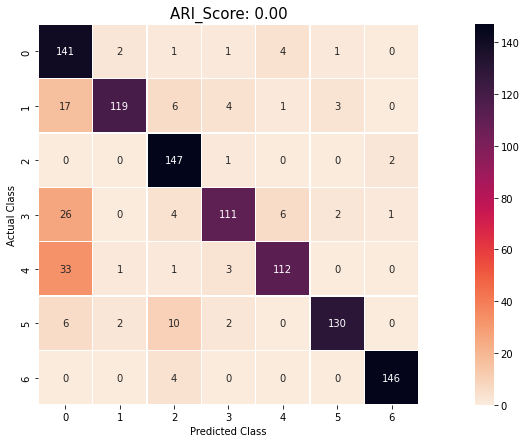

In [ ]:
conf_matrix(result_prediction['true_label'], result_prediction['Predicted_class'], 0)

We have a really nice accuracy but it is normal, we predict classes on images that trained the model. We could try with a new image from the net.

In [ ]:
img1 = "/content/gdrive/MyDrive/Flipkart/test_res/71I1KN14gcL._AC_SX522_.jpg" ### a smartwatch
img2 = "/content/gdrive/MyDrive/Flipkart/test_res/Objet_deco_Bibelot_Tete_de_cheval_en_metal_-_haut_20_cm_grande.jpg" ### Decoration
img3 = "/content/gdrive/MyDrive/Flipkart/test_res/landau.jpg" ### a stroller

In [ ]:
unknown_img = [img1, img2, img3]
result_unknown = {}

for img in unknown_img :
  image = cv2.imread(img)
  image = cv2.resize(image, (224, 224))
  image = np.expand_dims(image, axis=0) 
  output_class = resnet_model.predict(image)
  output_class = class_name[np.argmax(output_class)]
  result_unknown[img] = output_class

result_unknown =pd.DataFrame.from_dict(result_unknown, orient = 'index').reset_index().rename(columns={'index' : 'image_number', 0 : 'Predicted_class'})
result_unknown

1/1 [==============================] - 0s 21ms/step


image_number  \
0                                          /content/gdrive/MyDrive/Flipkart/test_res/71I1KN14gcL._AC_SX522_.jpg   
1  /content/gdrive/MyDrive/Flipkart/test_res/Objet_deco_Bibelot_Tete_de_cheval_en_metal_-_haut_20_cm_grande.jpg   
2                                                          /content/gdrive/MyDrive/Flipkart/test_res/landau.jpg   

               Predicted_class  
0                     Watches   
1  Home Decor & Festive Needs   
2  Home Decor & Festive Needs

We can see that predictions were correct for 2 of 3.

Let's see now what it would be if we use a pretrained model "out of the box" on our set of images.

## "Out of the Box" 

In [ ]:
from tensorflow.keras.models import Model

model = tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

### Adding a Flatten layer to have image features as vector 
OoB_resnet50 = Model(inputs=model.input, outputs=Flatten()(model.output))

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resNet

img_list = []

for image_num in range(len(df_image['image'])) :
  pathing = image_path + df_image['image'][image_num]
  img = load_img(pathing, target_size=(224, 224))  
  img = img_to_array(img)
  img_list.append(img)
    
img_list = np.asarray(img_list)
img_list = preprocess_input_resNet(img_list)

features_by_img = OoB_resnet50.predict(img_list)

33/33 [==============================] - 5s 109ms/step


ARI Score is :  0.428


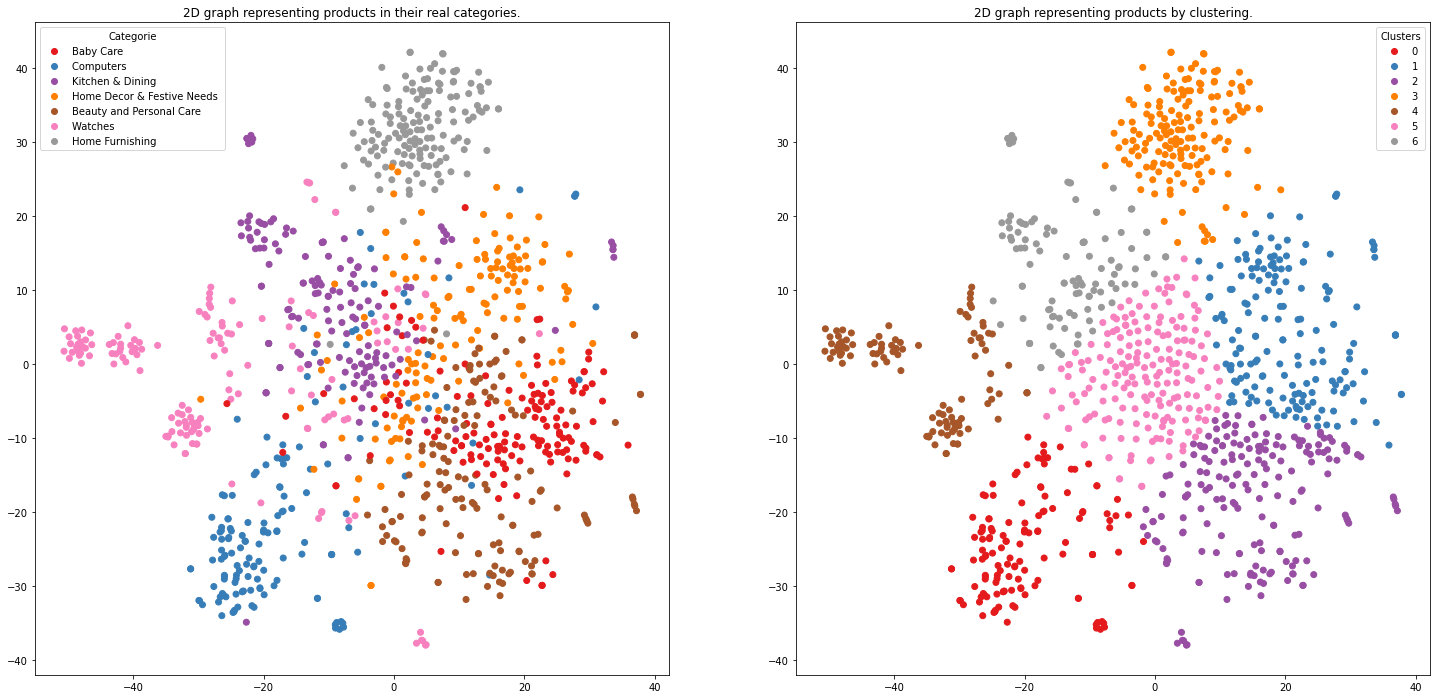

In [ ]:
ARI_Score, result_TSNE, pred_lab = ari_scoring(features_by_img)

plotting(result_TSNE, df_image['cluster'], pred_lab, ARI_Score)

With ResNet50 out of the box we've some good result, and as we can see we could, with some training, get much more accuracy.

## Bonus : CNN from Scratch

Here I would like to create a CNN and see how much accuracy i could get.

In [ ]:
from tensorflow.keras import layers

num_classes = 7

my_model = tf.keras.Sequential([
    layers.Conv2D(256,4, activation='relu'),
    layers.ReLU(),
    layers.AveragePooling2D(),
    layers.Conv2D(128,4, activation='relu'),
    layers.ReLU(),
    layers.Conv2D(64,4, activation='relu'),
    layers.ReLU(),
    layers.AveragePooling2D(),    
    layers.Conv2D(32,4, activation='relu'),
    layers.ReLU(),
    layers.Conv2D(16,4, activation='relu'),
    layers.ReLU(),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

my_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
  metrics=['accuracy'],)

In [ ]:
my_model.fit( 
    train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
21/21 [==============================] - 19s 635ms/step - loss: 7.2671 - accuracy: 0.1317 - val_loss: 1.9260 - val_accuracy: 0.1405
Epoch 2/3
21/21 [==============================] - 14s 623ms/step - loss: 2.1085 - accuracy: 0.2270 - val_loss: 1.9691 - val_accuracy: 0.1167
Epoch 3/3
21/21 [==============================] - 14s 630ms/step - loss: 1.8443 - accuracy: 0.2175 - val_loss: 2.0396 - val_accuracy: 0.2333


In [ ]:
my_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 221, 221, 256)     12544     
                                                                 
 re_lu_12 (ReLU)             (None, 221, 221, 256)     0         
                                                                 
 average_pooling2d_6 (Averag  (None, 110, 110, 256)    0         
 ePooling2D)                                                     
                                                                 
 conv2d_13 (Conv2D)          (None, 107, 107, 128)     524416    
                                                                 
 re_lu_13 (ReLU)             (None, 107, 107, 128)     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 104, 104, 64)      131136    
                                                      

In [ ]:
unknown_img = [img1, img2, img3]
result_bonus = {}

for img in unknown_img :
  image = cv2.imread(img)
  image = cv2.resize(image, (224, 224))
  image = np.expand_dims(image, axis=0) 
  output_class = my_model.predict(image)
  output_class = class_name[np.argmax(output_class)]
  result_bonus[img] = output_class

result_bonus =pd.DataFrame.from_dict(result_bonus, orient = 'index').reset_index().rename(columns={'index' : 'image_number', 0 : 'Predicted_class'})
result_bonus

1/1 [==============================] - 0s 14ms/step


image_number  \
0                                          /content/gdrive/MyDrive/Flipkart/test_res/71I1KN14gcL._AC_SX522_.jpg   
1  /content/gdrive/MyDrive/Flipkart/test_res/Objet_deco_Bibelot_Tete_de_cheval_en_metal_-_haut_20_cm_grande.jpg   
2                                                          /content/gdrive/MyDrive/Flipkart/test_res/landau.jpg   

               Predicted_class  
0                   Computers   
1  Home Decor & Festive Needs   
2            Kitchen & Dining

It predicted Computer for the smartwatch, Home Decor for the decoration and kitchen for the stroller.